In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import utils
import torch.nn as nn
from torchvision.models import resnet34
from torchsummary import summary

In [2]:
# Directory where dataset is stored
data_dir = 'data'

In [3]:
# Define the transformations for Training images
train_transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize images to 224x224 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally with probability 0.5
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Define the transformations for validation and test data
val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Define the ImageFolder dataset with the training transform
train_dataset = datasets.ImageFolder(root=data_dir+'/train', transform=train_transform)

# Define the validation and test datasets with their respective transforms
val_dataset = datasets.ImageFolder(root=data_dir+'/val', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=data_dir+'/test', transform=val_test_transform)

In [5]:
# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


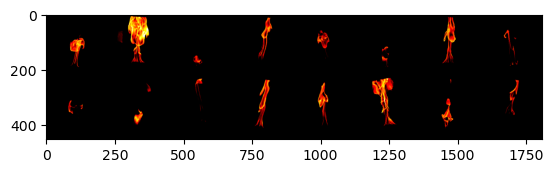

In [6]:
# Visualizing a Single Batch

# Get a batch of images
data_iter = iter(train_loader)
images, labels = data_iter.__next__()

# Convert images to numpy arrays
image_array = utils.make_grid(images).numpy()

# Transpose the image array to (height, width, channels)
image_array = np.transpose(image_array, (1, 2, 0))

# Display the images
plt.imshow(image_array)
plt.show()

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [8]:
def train(model, train_loader, val_loader, optimizer, num_epochs):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # Train the model
        train_loss = 0
        train_correct = 0
        train_total = 0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_loss_history.append(train_loss/len(train_loader))
        train_acc_history.append(train_correct/train_total)

        # Evaluate the model on the validation set
        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_correct/val_total)

        # Print the epoch loss and accuracy
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss_history[-1]:.4f}, Val Loss = {val_loss_history[-1]:.4f}, Train Acc = {train_acc_history[-1]:.4f}, Val Acc = {val_acc_history[-1]:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Method 1 -> ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [9]:
num_classes = 3
model_conv = resnet34(weights='IMAGENET1K_V1')
model_conv.fc = nn.Linear(model_conv.fc.in_features, num_classes)

for param in model_conv.parameters():
     param.requires_grad = False

for param in model_conv.fc.parameters():
     param.requires_grad = True
model_conv.to(device)

optimizer = torch.optim.Adam(model_conv.fc.parameters(), lr=1e-4)

train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(model_conv, train_loader, val_loader, optimizer, num_epochs=10)

Epoch 1/10: Train Loss = 0.9268, Val Loss = 0.7731, Train Acc = 0.5813, Val Acc = 0.7400
Epoch 2/10: Train Loss = 0.6984, Val Loss = 0.6433, Train Acc = 0.7854, Val Acc = 0.8467
Epoch 3/10: Train Loss = 0.5871, Val Loss = 0.5556, Train Acc = 0.8104, Val Acc = 0.8700
Epoch 4/10: Train Loss = 0.5022, Val Loss = 0.5100, Train Acc = 0.8633, Val Acc = 0.8767
Epoch 5/10: Train Loss = 0.4669, Val Loss = 0.4766, Train Acc = 0.8604, Val Acc = 0.8833
Epoch 6/10: Train Loss = 0.4157, Val Loss = 0.4521, Train Acc = 0.8850, Val Acc = 0.8733
Epoch 7/10: Train Loss = 0.3844, Val Loss = 0.4313, Train Acc = 0.8908, Val Acc = 0.8767
Epoch 8/10: Train Loss = 0.3618, Val Loss = 0.4224, Train Acc = 0.8925, Val Acc = 0.8800
Epoch 9/10: Train Loss = 0.3418, Val Loss = 0.3997, Train Acc = 0.8958, Val Acc = 0.8800
Epoch 10/10: Train Loss = 0.3349, Val Loss = 0.3875, Train Acc = 0.9025, Val Acc = 0.8800


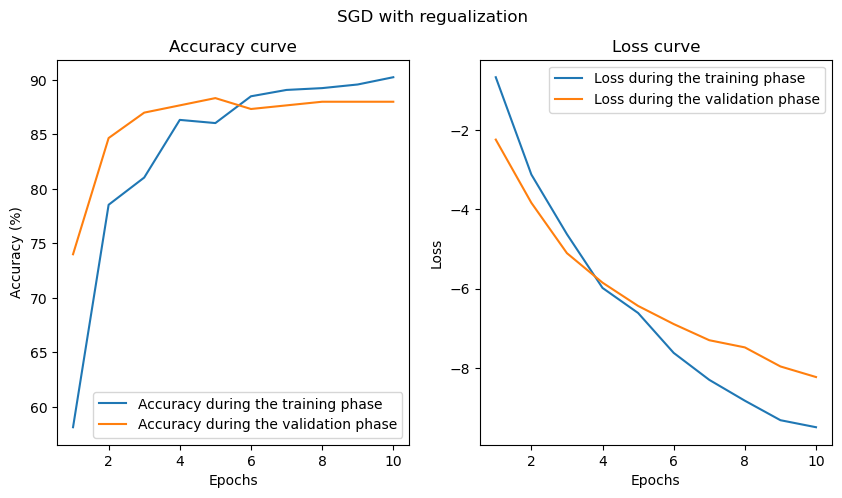

In [10]:
# Plotting the accuracy and loss graph:

NUM_OF_EPOCHS = 10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

fig.suptitle("SGD with regualization")


axes[0].plot(range(1, NUM_OF_EPOCHS + 1), np.array(train_acc_history) * 100, label = "Accuracy during the training phase")
axes[0].plot(range(1, NUM_OF_EPOCHS + 1), np.array(val_acc_history) * 100, label = "Accuracy during the validation phase")
axes[0].set_title("Accuracy curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy (%)")
axes[0].legend()


axes[1].plot(range(1, NUM_OF_EPOCHS + 1),  20 * np.log10(np.array(train_loss_history)), label = "Loss during the training phase")
axes[1].plot(range(1, NUM_OF_EPOCHS + 1), 20 * np.log10(np.array(val_loss_history)), label = "Loss during the validation phase")
axes[1].set_title("Loss curve")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

Method 2 -> Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.

In [11]:
num_classes = 3
model = resnet34(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6,weight_decay=0.0001)

train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(model, train_loader, val_loader, optimizer, num_epochs=20)

Epoch 1/20: Train Loss = 0.8759, Val Loss = 0.6699, Train Acc = 0.6175, Val Acc = 0.7767
Epoch 2/20: Train Loss = 0.4864, Val Loss = 0.3917, Train Acc = 0.8746, Val Acc = 0.9167
Epoch 3/20: Train Loss = 0.3169, Val Loss = 0.2714, Train Acc = 0.9213, Val Acc = 0.9267
Epoch 4/20: Train Loss = 0.2411, Val Loss = 0.2205, Train Acc = 0.9354, Val Acc = 0.9333
Epoch 5/20: Train Loss = 0.2099, Val Loss = 0.1930, Train Acc = 0.9333, Val Acc = 0.9433
Epoch 6/20: Train Loss = 0.1708, Val Loss = 0.1878, Train Acc = 0.9433, Val Acc = 0.9267
Epoch 7/20: Train Loss = 0.1608, Val Loss = 0.1616, Train Acc = 0.9508, Val Acc = 0.9433
Epoch 8/20: Train Loss = 0.1533, Val Loss = 0.1663, Train Acc = 0.9504, Val Acc = 0.9267
Epoch 9/20: Train Loss = 0.1401, Val Loss = 0.1586, Train Acc = 0.9542, Val Acc = 0.9300
Epoch 10/20: Train Loss = 0.1276, Val Loss = 0.1508, Train Acc = 0.9554, Val Acc = 0.9367
Epoch 11/20: Train Loss = 0.1181, Val Loss = 0.1311, Train Acc = 0.9617, Val Acc = 0.9500
Epoch 12/20: Train 

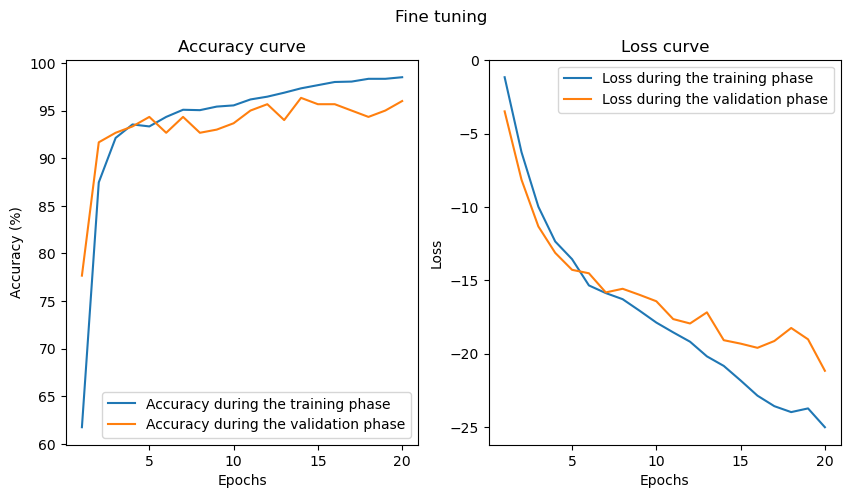

In [12]:
# Plotting the accuracy and loss graph:

NUM_OF_EPOCHS = 20

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

fig.suptitle("Fine tuning")


axes[0].plot(range(1, NUM_OF_EPOCHS + 1), np.array(train_acc_history) * 100, label = "Accuracy during the training phase")
axes[0].plot(range(1, NUM_OF_EPOCHS + 1), np.array(val_acc_history) * 100, label = "Accuracy during the validation phase")
axes[0].set_title("Accuracy curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy (%)")
axes[0].legend()


axes[1].plot(range(1, NUM_OF_EPOCHS + 1),  20 * np.log10(np.array(train_loss_history)), label = "Loss during the training phase")
axes[1].plot(range(1, NUM_OF_EPOCHS + 1), 20 * np.log10(np.array(val_loss_history)), label = "Loss during the validation phase")
axes[1].set_title("Loss curve")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

In [13]:
summary(model.to('cpu'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [14]:
# Define the path to the image you want to load
img_path = os.path.join(data_dir, 'train', 'ethanol', 'Ethanol_Full_0036.JPG')

# Load and transform the image
img = Image.open(img_path)
img_tensor = val_test_transform(img)
img_tensor = img_tensor.unsqueeze(0)  # Add a batch dimension

In [15]:
def visualize_hook(module, input, output):
    plt.figure(figsize=(15, 15))
    for i in range(output.size(1)):
        plt.subplot(8, 8, i + 1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()

In [16]:
# # Choose a specific layer and register the hook
# layer_to_visualize = model.layer3[0].conv1
# hook = layer_to_visualize.register_forward_hook(visualize_hook)
# # Run a single image through the model
# image = img_tensor  # Replace this with a real image from the dataset
# _ = model(image)
# hook.remove()     # Remove the hook

Analysis

BaseLine Model - ResNet

In [17]:
num_classes = 3
model_base = resnet34(weights='IMAGENET1K_V1')
model_base.fc = nn.Linear(model_base.fc.in_features, num_classes)

In [18]:
y_pred = []
y_true = []

# iterate over test data
for images, labels in test_loader:
        output = model_base(images) # Feed Network
        predictions = torch.max(output.data,1)[1]
        y_pred.extend(predictions.cpu().numpy()) # Save Prediction
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth

cf_matrix_base = confusion_matrix(y_true, y_pred)

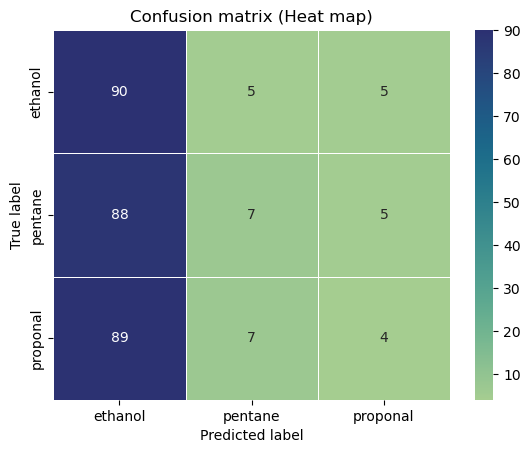

In [19]:
classes = ['ethanol','pentane','proponal']

# Create heatmap with annotated cells
heat = sns.heatmap(cf_matrix_base, annot=True, fmt='d', linewidth=0.5, cmap='crest',xticklabels=classes, yticklabels=classes)

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix (Heat map)')

# Show plot
plt.show()

In [20]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 33.67%


Pre - Trained Model

In [21]:
y_pred = []
y_true = []

model.to(device)

# iterate over test data
for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images) # Feed Network
        predictions = torch.max(output.data,1)[1]
        y_pred.extend(predictions.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

cf_matrix = confusion_matrix(y_true, y_pred)

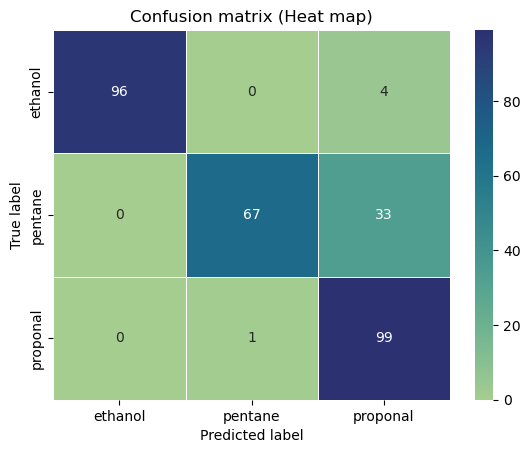

In [22]:
classes = ['ethanol','pentane','proponal']

# Create heatmap with annotated cells
heat = sns.heatmap(cf_matrix, annot=True, fmt='d', linewidth=0.5, cmap='crest',xticklabels=classes, yticklabels=classes)

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix (Heat map)')

# Show plot
plt.show()

In [23]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 87.33%
